In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
# from torch.utils.tensorboard import SummaryWriter

from PIL import Image
from skimage.color import rgba2rgb
import cv2
from IPython.display import display, clear_output
from math import *
import time

from os import makedirs, path
from copy import deepcopy

from tqdm import tqdm

from leniaCA import leniaCA
import pygame, pygame_gui

pygame 2.0.1 (SDL 2.0.14, Python 3.9.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
Rk = 200
xm, ym = torch.meshgrid(torch.linspace(-1, 1, Rk), torch.linspace(-1, 1, Rk))
rm = torch.sqrt(xm ** 2 + ym ** 2).cuda() 

alpha = 4
k = torch.exp( alpha - alpha / (4*rm*(1 - rm)) )

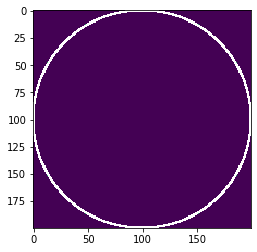

In [3]:
plt.imshow(k.cpu().numpy())

In [4]:
def LMB_make(state, r=5, s=1):
    '''
    left click to make
    r: radius of brush
    s: smoothing / sigma
    '''
    xcl, ycl = pygame.mouse.get_pos()
    xcl, ycl = int(xcl/UPSCALE), int(ycl/UPSCALE)
    
    # radial blur
    xm, ym = torch.meshgrid(torch.linspace(-1, 1, 2*r), torch.linspace(-1, 1, 2*r))
    rm = torch.sqrt(xm**2 + ym**2).type(torch.double)
    blur = torch.exp(-rm**2 / s**2)
    blur = torch.where(rm <= 1., blur, 0.) # circular mask
    
    xslice = range(xcl - r, xcl + r)
    yslice = range(ycl - r, ycl + r)
    for count_i, i in enumerate(xslice):
        for count_j, j in enumerate(yslice):
            i = i % RESX
            j = j % RESY
            state[:, :, i, j] = 1.
    return state
    
    
def RMB_del(state, r=5, s=1):
    '''
    right click to erase
    r: radius of eraser
    s: smoothing / sigma
    '''
    xcl, ycl = pygame.mouse.get_pos()
    xcl, ycl = int(xcl/UPSCALE), int(ycl/UPSCALE)
    
    # radial blur
    xm, ym = torch.meshgrid(torch.linspace(-1, 1, 2*r), torch.linspace(-1, 1, 2*r))
    rm = torch.sqrt(xm**2 + ym**2).type(torch.double)
    blur = (1 - torch.exp(-rm**2 / s**2))
    blur = torch.where(rm <= 1., blur, 1.) # circular mask
    
    xslice = range(xcl - r, xcl + r)
    yslice = range(ycl - r, ycl + r)
    for count_i, i in enumerate(xslice):
        for count_j, j in enumerate(yslice):
            i = i % RESX
            j = j % RESY
            state[:, :, i, j] = -1.
    return state
    
def WHEEL_scroll(value, direction):
    
    return value + direction * 0.001

In [5]:
def print_num(num):
    fps = f'{num:.3f}'
    fps_text = font.render(fps, 1, pygame.Color("white"))
    fps_bg = pygame.Surface((fps_text.get_height(),fps_text.get_width()))  # the size of your rect
    fps_bg.set_alpha(50)                # alpha level
    fps_bg.fill((255,255,255))           # this fills the entire surface

    fps_surf = pygame.Surface((fps_bg.get_height(), fps_bg.get_width()))
    fps_surf.blit(fps_bg, (0, 0))
    fps_surf.blit(fps_text, (0, 0))
    return fps_surf

# Test

In [6]:
CHANNELS=1
RADIUS=26
ca = leniaCA(CHANNELS=CHANNELS, RADIUS=RADIUS).cuda() 

In [7]:
# brush properties
r = 20
s = 1

In [8]:
# resolution of grid
RESX=720
RESY=480

# pygame stuff
######################################
pygame.init()
size = RESX, RESY
# screen = pygame.display.set_mode(size)
screen = pygame.Surface(size)
UPSCALE = 1
RESXup, RESYup = int(RESX*UPSCALE), int(RESY*UPSCALE)
upscaled_screen = pygame.display.set_mode([RESXup, RESYup])

running = True
time_ticking = True
LMB_trigger = False
RMB_trigger = False
WHEEL_trigger = False
PARAM_INDEX = 0 

clock = pygame.time.Clock()
font = pygame.font.SysFont("Noto Sans", 12)
def update_fps(clock, font):
    fps = str(int(clock.get_fps()))
    fps_text = font.render(fps, 1, pygame.Color("white"))
    fps_bg = pygame.Surface((fps_text.get_height(),fps_text.get_width()))  # the size of your rect
    fps_bg.set_alpha(50)                # alpha level
    fps_bg.fill((255,255,255))           # this fills the entire surface

    fps_surf = pygame.Surface((fps_bg.get_height(), fps_bg.get_width()))
    fps_surf.blit(fps_bg, (0, 0))
    fps_surf.blit(fps_text, (0, 0))
    return fps_surf
######################################

# CENTER SEED
# seed = torch.cuda.FloatTensor(np.zeros((CHANNELS, RESX, RESY))).unsqueeze(0)
# seed[:, 3:, RESX//2, RESY//2] = 1
# state = seed.clone()

state = ca.initGrid((RESX, RESY))

# inject noise
signal_injection = torch.zeros(size=state.shape)
noise_amp = 1.
noise_idx = slice(4, 10)

update_rate = 1.
ticker = 0.
sink = False
export_imgs = False
imgs = []

with torch.no_grad():
    while running:              
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
            
            # add/erase 
            if event.type == pygame.MOUSEBUTTONDOWN:
                if event.button == 1:
                    LMB_trigger = True
                if event.button == 3:
                    RMB_trigger = True
            if event.type == pygame.MOUSEBUTTONUP:
                if event.button == 1:
                    LMB_trigger = False
                if event.button == 3:
                    RMB_trigger = False
            
            if event.type== pygame.KEYDOWN and event.key == pygame.K_LEFT:
                PARAM_INDEX = (PARAM_INDEX - 1) % 2
            if event.type== pygame.KEYDOWN and event.key == pygame.K_RIGHT:
                PARAM_INDEX = (PARAM_INDEX + 1) % 2
            if event.type == pygame.MOUSEWHEEL:
                WHEEL_trigger = True
                direction = event.y     
                
            if event.type == pygame.KEYDOWN and event.key == pygame.K_SPACE:
                # generate random kernel params
                ca.rule.sigma = np.abs(np.random.randn() / 10)
                ca.rule.mu = np.abs(np.random.randn())
                ca.rule.alpha = np.abs(np.random.normal(4))
                ca.rule.K = nn.Parameter(ca.rule.generate_kernel())
#                 ca.rule.K = nn.Parameter(ca.rule.generate_random_kernel())
#                 ca.rule.K = nn.Parameter(ca.rule.generate_cppn_kernel())
#                 ca.rule.K = nn.Parameter(ca.rule.generate_cppn_kernels())

            if event.type== pygame.KEYDOWN and event.key == pygame.K_s:
                # toggle sink
                sink = not sink
            if event.type== pygame.KEYDOWN and event.key == pygame.K_e:
                # export video
                export_imgs = not export_imgs
            if event.type== pygame.KEYDOWN and event.key == pygame.K_p:
                # pause/toggle time
                time_ticking = not time_ticking                
            if event.type== pygame.KEYDOWN and event.key == pygame.K_r:
                # start from seed 
                state = ca.initGrid((RESX, RESY))
                

        mouse_pos = pygame.mouse.get_pos()
        if LMB_trigger:
            state = LMB_make(state, r=r, s=s)
        if RMB_trigger:
            state = RMB_del(state, r=r, s=s)
        if WHEEL_trigger:
            if PARAM_INDEX == 0:
                ca.rule.mu = WHEEL_scroll(ca.rule.mu, direction)
            if PARAM_INDEX == 1:
                ca.rule.sigma = WHEEL_scroll(ca.rule.sigma, direction)
            WHEEL_trigger = False
        
            
#         nx = state.cpu()[:, cdim_order].numpy()[0, 0, :, :].transpose(1, 2, 0)
        if CHANNELS == 1:
            nx = state.cpu().numpy()[0, 0, :, :]
        else:
            nx = state.cpu().numpy()[0, 0:3, :, :].transpose(1, 2, 0)
        nx = nx * 255

        if time_ticking:
            state = ca.forward(state)
            ticker += 1
    
            if sink:
                xv, yv = torch.linspace(-1, 1, RESX), torch.linspace(-RESY/RESX, RESY/RESX, RESY)
                X, Y = torch.meshgrid(xv, yv)
                amp = 0.00
                w = 30
                R = torch.sqrt(X**2 + Y**2).cuda()
                state = torch.clip(torch.where(R > 0.5, state - 0.05*R*torch.ones_like(state).cuda(), state), 0, 1)

            if export_imgs:
                imgs.append(nx)
        
    
#         signal_injection[:, noise_idx, :, :] = noise_amp * torch.randn(size=(signal_injection[:, noise_idx, :, :].shape))
#         signal_injection = signal_injection.to('cuda')
#         state = state + signal_injection

        pygame.surfarray.blit_array(screen, nx)        
        frame = pygame.transform.scale(screen, (RESXup, RESYup))
        upscaled_screen.blit(frame, frame.get_rect())
        upscaled_screen.blit(update_fps(clock, font), (10,0))
        # ca params
        upscaled_screen.blit(print_num(ca.rule.mu), (10,20))
        upscaled_screen.blit(print_num(ca.rule.sigma), (50,20))
        pygame.display.flip()
        clock.tick(240)
        
pygame.quit()


In [9]:
fname = time.strftime("%Y%m%d-%H%M%S")
# out = cv2.VideoWriter(f'videos/CA-{fname}.avi',cv2.VideoWriter_fourcc(*'DIVX'), 60, (RESX, RESY), 3)
out = cv2.VideoWriter(f'videos/CA-{fname}.mp4',cv2.VideoWriter_fourcc(*'MP4V'), 60, (RESX, RESY), 1)


for img in imgs:
#     img = np.uint8(cv2.cvtColor(img, cv2.COLOR_RGB2BGR)*255.0)
    img = np.uint8(cv2.cvtColor(img, cv2.COLOR_RGB2BGR)).transpose(1, 0, 2)
    out.write(img)
out.release()

(array([268200.,   1532.,   1340.,   1294.,   1242.,   1271.,   1226.,
          1350.,   1552.,  66593.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

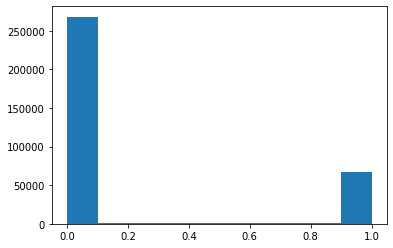

In [10]:
plt.hist(state.reshape(-1).cpu().detach().numpy())

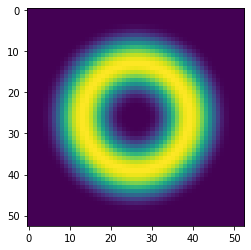

In [11]:
plt.imshow(ca.rule.K.detach().cpu().numpy()[0, 0])

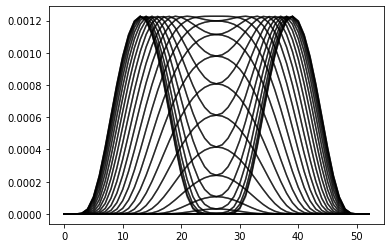

In [12]:
plt.plot(ca.rule.K.detach().cpu().numpy()[0, 0], c='k', alpha=0.6);